# Getting Data From Kaggle

In [1]:
# Get data from Kaggle
!pip install kaggle
!mkdir ~/.kaggle
!mkdir /content/.kaggle
!ls ~/.kaggle

import json
token = {"username":"mielgosez", "key":"46ef90eb86d527d54aca090759ccbef9"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

print("1. Downloading datasets")
!kaggle competitions download -c vsb-power-line-fault-detection -p /content/
print("2.  Moving train set to train folder")
!mkdir /content/train
!unzip -qq /content/train.parquet.zip -d /content/train
print("3. Moving test set to test folder")
!mkdir /content/test
!unzip -qq /content/test.parquet.zip -d /content/test

- path is now set to: {/content}
1. Downloading datasets
  0% 0.00/257k [00:00<?, ?B/s]
100% 257k/257k [00:00<00:00, 38.2MB/s]
  0% 0.00/115k [00:00<?, ?B/s]
100% 115k/115k [00:00<00:00, 34.9MB/s]
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 48.3MB/s]
100% 6.97G/6.97G [01:25<00:00, 53.6MB/s]
100% 6.97G/6.97G [01:25<00:00, 87.4MB/s]
100% 3.01G/3.02G [00:33<00:00, 103MB/s] 
100% 3.02G/3.02G [00:33<00:00, 96.0MB/s]
2.  Moving train set to train folder
3. Moving test set to test folder


In [0]:
import pandas as pd
import numpy as np

path_data = '/content/'
meta_train = pd.read_csv(path_data + 'metadata_train.csv')

# outliers phases in each measurement
measurements = meta_train.groupby(['id_measurement'])['target'].sum().reset_index()

# outlier ratio
ratio = measurements.groupby(['target']).size().to_frame('outlier')
ratio['percentage'] = ratio['outlier']/len(measurements)

print(ratio)
ratio_outlier = ratio['percentage'].iloc[-1]


total = 1000
split = 0.8



def split_data(measurements, sample, ratio):
    df_outlier = measurements[measurements['target']==3].sample(int(np.round(sample*ratio)))
    print('outliers in dataset', len(df_outlier))
    df = measurements[measurements['target']==0].sample(int(sample-len(df_outlier)))
    print('normal measurement in dataset', len(df))
    # merge
    df = df.append(df_outlier).reset_index(drop=True)
    return df

print('train dataset')
train = split_data(measurements, sample=total*split, ratio=ratio_outlier)
train_signals = pd.merge(meta_train, train['id_measurement'], how='inner')


        outlier  percentage
target                     
0          2710    0.933196
1            19    0.006543
2            19    0.006543
3           156    0.053719
train dataset
outliers in dataset 43
normal measurement in dataset 757


Index(['0', '1', '2'], dtype='object')


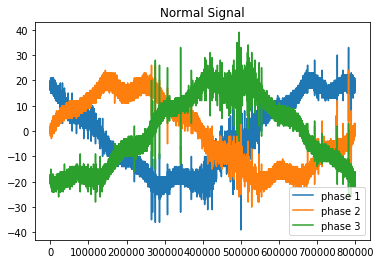

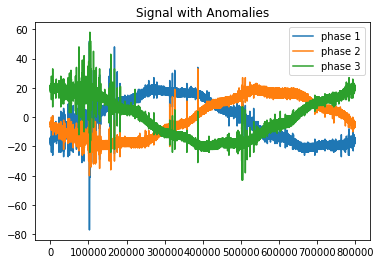

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
# Load Normal data
metadata = pd.read_csv('/content/metadata_train.csv')
signal_ids = list(metadata[metadata["id_measurement"] == 0]["signal_id"].values)
signal_ids = [str(item) for item in signal_ids]
train_0 = pd.read_parquet('/content/train/train.parquet', 
                        engine='pyarrow', 
                        columns=signal_ids)
train_0.to_csv('0.csv', index=False)
print(train_0.columns)
# Load Anomalous data
signal_ids = list(metadata[metadata["id_measurement"] == 1]["signal_id"].values)
signal_ids = [str(item) for item in signal_ids]
train_1 = pd.read_parquet('/content/train/train.parquet',
                        engine='pyarrow', 
                        columns=signal_ids)
train_1.to_csv('1.csv', index=False)
signal_ids = list(metadata[metadata["id_measurement"] == 2]["signal_id"].values)
signal_ids = [str(item) for item in signal_ids]
train_2 = pd.read_parquet('/content/train/train.parquet',
                        engine='pyarrow', 
                        columns=signal_ids)
train_2.to_csv('2.csv', index=False)
signal_ids = list(metadata[metadata["id_measurement"] == 3]["signal_id"].values)
signal_ids = [str(item) for item in signal_ids]
train_3 = pd.read_parquet('/content/train/train.parquet',
                        engine='pyarrow', 
                        columns=signal_ids)
train_3.to_csv('3.csv', index=False)

# Plot Normal signal
plt.plot(train_0["0"], label="phase 1")
plt.plot(train_0["1"], label="phase 2")
plt.plot(train_0["2"], label="phase 3")
plt.legend()
plt.title("Normal Signal")
plt.show()
# Plot Abnormal signal
plt.plot(train_1["3"], label="phase 1")
plt.plot(train_1["4"], label="phase 2")
plt.plot(train_1["5"], label="phase 3")
plt.legend()
plt.title("Signal with Anomalies")
plt.show()

# Fourier Transform

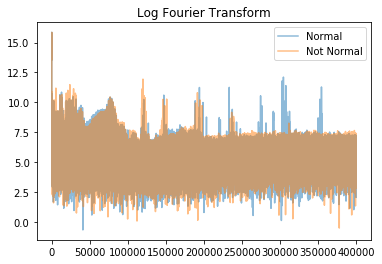

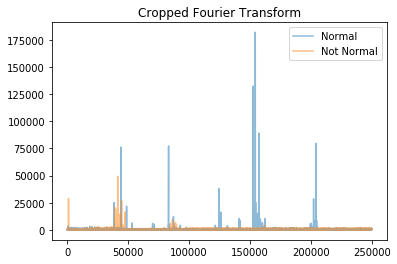

In [0]:
import numpy as np
fourier_signal_0 = np.fft.rfft(train_0["0"])
fourier_signal_1 = np.fft.rfft(train_1["3"])

plt.plot(np.log(np.abs(fourier_signal_0)), alpha=0.5, label="Normal")
plt.plot(np.log(np.abs(fourier_signal_1)), alpha=0.5, label="Not Normal")
plt.legend()
plt.title("Log Fourier Transform")
plt.show()

plt.plot(np.abs(fourier_signal_0)[150000:], alpha=0.5, label="Normal")
plt.plot(np.abs(fourier_signal_1)[150000:], alpha=0.5, label="Not Normal")
plt.legend()
plt.title("Cropped Fourier Transform")
plt.show()

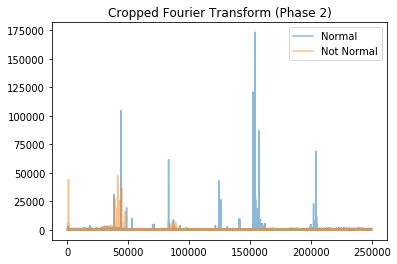

In [0]:
fourier_signal_0 = np.fft.rfft(train_0["1"])
fourier_signal_1 = np.fft.rfft(train_1["4"])

plt.plot(np.abs(fourier_signal_0)[150000:], label="Normal", alpha=0.5)
plt.plot(np.abs(fourier_signal_1)[150000:], label="Not Normal", alpha=0.5)
plt.legend()
plt.title("Cropped Fourier Transform (Phase 2)")
plt.show()

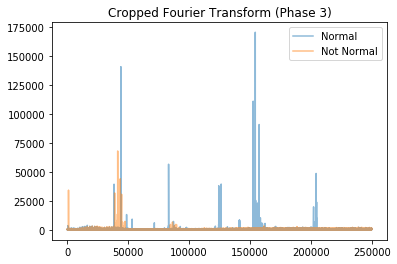

In [0]:
fourier_signal_0 = np.fft.rfft(train_0["2"])
fourier_signal_1 = np.fft.rfft(train_1["5"])

plt.plot(np.abs(fourier_signal_0)[150000:], label="Normal", alpha=0.5)
plt.plot(np.abs(fourier_signal_1)[150000:], label="Not Normal", alpha=0.5)
plt.legend()
plt.title("Cropped Fourier Transform (Phase 3)")
plt.show()

# Deeper Study on Fourier Transform

In [0]:
import pandas as pd
!pip install pyarrow
import pyarrow.parquet as pq
import os
import numpy as np
import matplotlib.pyplot as plt

metadata = pd.read_csv('/content/metadata_train.csv')

target_values = metadata[["id_measurement", "target"]]
target_values = target_values.groupby("id_measurement").sum()
target_values["target"] = target_values["target"].astype(int)

def get_fft_auc(line, method:str="auc"):
  y = np.abs(np.fft.rfft(line))[150000:]
  if method == "argmax":
    area = np.argmax(y)
  elif method == "max":
    area = max(y)
  elif method == "auc":
    # Get area under the curve with numpy using trapezoid rule
    area = np.trapz(y)
  else:
    raise Exception(method+" is not a recognized method")
  return area

id_measurement = list(metadata["id_measurement"].unique())
info_argmax = []
info_max = []
info_auc = []
for i in id_measurement[:3000]:
  # Get signal from parquet
  signal_ids = list(metadata[metadata["id_measurement"] == i]["signal_id"].values)
  signal_ids = [str(item) for item in signal_ids]
  train = pd.read_parquet('/content/train/train.parquet', 
                         engine='pyarrow', 
                         columns=signal_ids)
  # Get info
  info_argmax.append([get_fft_auc(train[train.columns[0]], method="argmax"),
               get_fft_auc(train[train.columns[1]], method="argmax"),
               get_fft_auc(train[train.columns[2]], method="argmax"),
               target_values.loc[i, "target"]])
  info_max.append([get_fft_auc(train[train.columns[0]], method="max"),
               get_fft_auc(train[train.columns[1]], method="max"),
               get_fft_auc(train[train.columns[2]], method="max"),
               target_values.loc[i, "target"]])
  info_auc.append([get_fft_auc(train[train.columns[0]], method="auc"),
               get_fft_auc(train[train.columns[1]], method="auc"),
               get_fft_auc(train[train.columns[2]], method="auc"),
               target_values.loc[i, "target"]])
  if i % 100 == 0:
    print("Current iteration:"+str(i))
 
info_argmax = pd.DataFrame(info_argmax, columns=["line_1", "line_2", "line_3", "target"])
info_max = pd.DataFrame(info_max, columns=["line_1", "line_2", "line_3", "target"])
info_auc = pd.DataFrame(info_auc, columns=["line_1", "line_2", "line_3", "target"])
info_auc.head(10)

Current iteration:0
Current iteration:100
Current iteration:200
Current iteration:300
Current iteration:400
Current iteration:500
Current iteration:600
Current iteration:700
Current iteration:800
Current iteration:900
Current iteration:1000
Current iteration:1100
Current iteration:1200
Current iteration:1300
Current iteration:1400
Current iteration:1500
Current iteration:1600
Current iteration:1700
Current iteration:1800
Current iteration:1900
Current iteration:2000
Current iteration:2100
Current iteration:2200
Current iteration:2300
Current iteration:2400
Current iteration:2500
Current iteration:2600
Current iteration:2700
Current iteration:2800
Current iteration:2900


,line_1,line_2,line_3,target
0,1.059455e+08,9.086394e+07,1.019816e+08,0
1,1.159746e+08,8.971681e+07,1.128970e+08,3
2,9.763803e+07,8.498083e+07,8.634647e+07,0
3,4.719689e+08,1.982185e+08,4.249782e+08,0
4,1.305930e+08,9.605408e+07,1.335613e+08,0
5,8.989969e+07,8.514379e+07,9.223902e+07,0
6,1.712454e+08,1.576049e+08,1.362280e+08,0
7,7.295363e+07,7.128472e+07,7.261987e+07,0
8,1.071991e+08,8.872425e+07,1.154228e+08,0
9,8.377603e+07,7.829940e+07,8.270127e+07,0


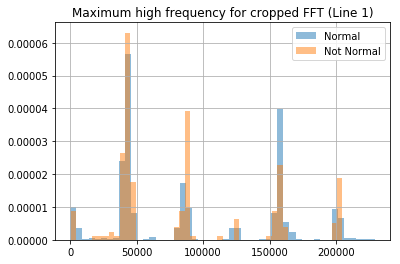

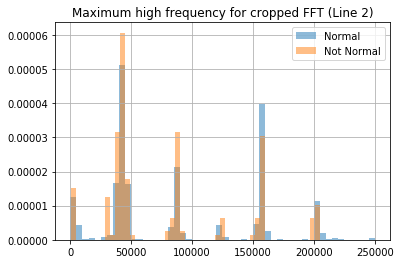

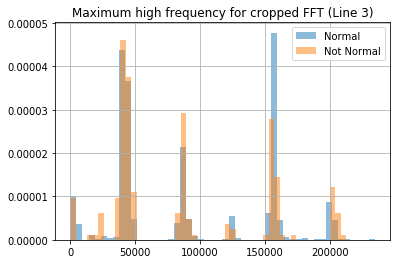

In [0]:
info_argmax[info_argmax["target"] == 0]["line_1"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_argmax[info_argmax["target"] > 0]["line_1"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("Maximum high frequency for cropped FFT (Line 1)")
plt.show()

info_argmax[info_argmax["target"] == 0]["line_2"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_argmax[info_argmax["target"] > 0]["line_2"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("Maximum high frequency for cropped FFT (Line 2)")
plt.show()

info_argmax[info_argmax["target"] == 0]["line_3"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_argmax[info_argmax["target"] > 0]["line_3"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("Maximum high frequency for cropped FFT (Line 3)")
plt.show()

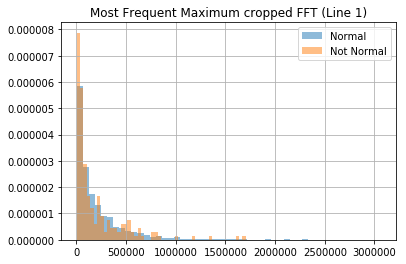

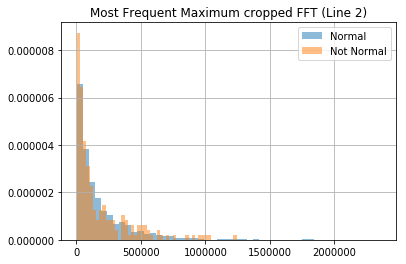

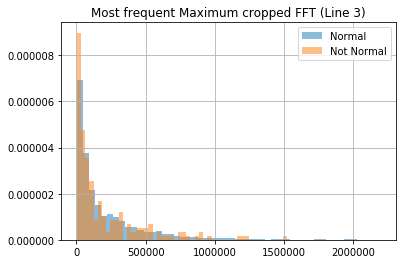

In [0]:
info_max[info_max["target"] == 0]["line_1"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_max[info_max["target"] > 0]["line_1"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("Most Frequent Maximum cropped FFT (Line 1)")
plt.show()

info_max[info_max["target"] == 0]["line_2"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_max[info_max["target"] > 0]["line_2"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("Most Frequent Maximum cropped FFT (Line 2)")
plt.show()

info_max[info_max["target"] == 0]["line_3"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_max[info_max["target"] > 0]["line_3"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("Most frequent Maximum cropped FFT (Line 3)")
plt.show()

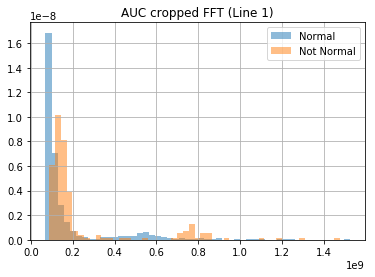

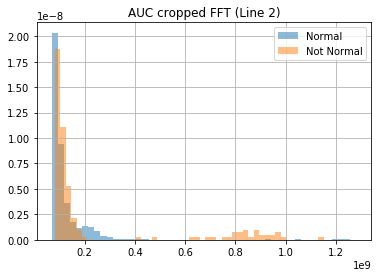

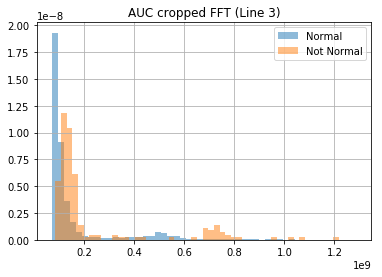

In [0]:
info_auc[info_auc["target"] == 0]["line_1"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_auc[info_auc["target"] > 0]["line_1"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("AUC cropped FFT (Line 1)")
plt.show()

info_auc[info_auc["target"] == 0]["line_2"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_auc[info_auc["target"] > 0]["line_2"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("AUC cropped FFT (Line 2)")
plt.show()

info_auc[info_auc["target"] == 0]["line_3"].hist(bins=50, alpha=0.5, density=True, label="Normal")
info_auc[info_auc["target"] > 0]["line_3"].hist(bins=50, alpha=0.5, density=True, label="Not Normal")
plt.legend()
plt.title("AUC cropped FFT (Line 3)")
plt.show()

# Further Studies

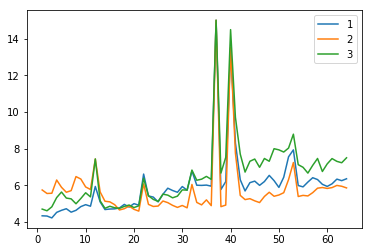

In [0]:
fourier_0 = np.abs(np.fft.rfft(train_0["0"]))[(150000-47):]
fourier_1 = np.abs(np.fft.rfft(train_0["1"]))[(150000-47):]
fourier_2 = np.abs(np.fft.rfft(train_0["2"]))[(150000-47):]

n = int(len(A)/64)
tagger = []
[tagger.extend([item+1]*n) for item in range(64)]
tagger = sorted(tagger)
fourier_matrix = pd.DataFrame({"phase_1": fourier_0,
                               "phase_2": fourier_1,
                               "phase_3": fourier_2,
                               "tagger": tagger})
fourier_matrix = fourier_matrix.groupby("tagger").mean()

# Magnitudes are multiplied by 16 in order to get a maximum of 255 for the joint
# distribution
fourier_matrix["phase_1"] = fourier_matrix["phase_1"]*16/max(fourier_matrix["phase_1"])
fourier_matrix["phase_2"] = fourier_matrix["phase_2"]*16/max(fourier_matrix["phase_2"])
fourier_matrix["phase_3"] = fourier_matrix["phase_3"]*16/max(fourier_matrix["phase_3"])
plt.plot(fourier_matrix["phase_1"], label="1")
plt.plot(fourier_matrix["phase_2"], label="2")
plt.plot(fourier_matrix["phase_3"], label="3")
plt.legend()
plt.show()

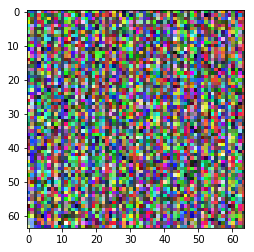

In [0]:
image_fft = np.zeros((64, 64, 3))
image_fft[:, :, 0] = np.matmul(np.transpose([fourier_matrix["phase_1"]]), [fourier_matrix["phase_2"]])
image_fft[:, :, 1] = np.matmul(np.transpose([fourier_matrix["phase_1"]]), [fourier_matrix["phase_3"]])
image_fft[:, :, 2] = np.matmul(np.transpose([fourier_matrix["phase_2"]]), [fourier_matrix["phase_3"]])
from PIL import Image
img = Image.fromarray(image_fft,
                      'RGB')
plt.imshow(img)

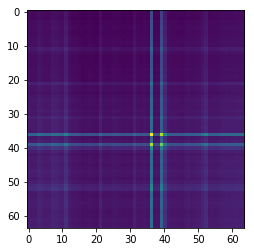

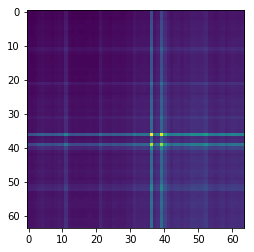

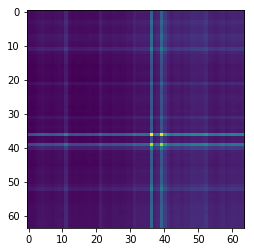

In [0]:
plt.imshow(np.matmul(np.transpose([fourier_matrix["phase_1"]]), [fourier_matrix["phase_2"]]))
plt.show()
plt.imshow(np.matmul(np.transpose([fourier_matrix["phase_1"]]), [fourier_matrix["phase_3"]]))
plt.show()
plt.imshow(np.matmul(np.transpose([fourier_matrix["phase_2"]]), [fourier_matrix["phase_3"]]))
plt.show()

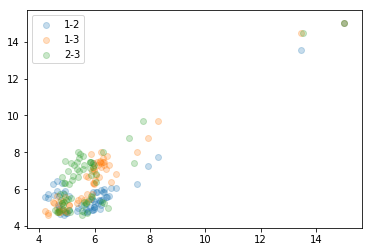

In [0]:
plt.scatter(fourier_matrix["phase_1"], fourier_matrix["phase_2"],alpha=0.25, label="1-2")
plt.scatter(fourier_matrix["phase_1"], fourier_matrix["phase_3"],alpha=0.25, label="1-3")
plt.scatter(fourier_matrix["phase_2"], fourier_matrix["phase_3"],alpha=0.25, label="2-3")
plt.legend()
plt.show()

## Anomalous

3907
250048


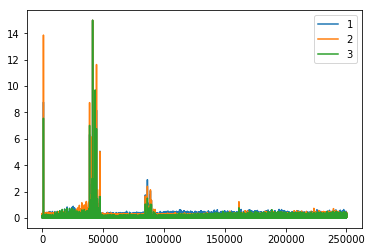

In [0]:
fourier_a0 = np.abs(np.fft.rfft(train_1["3"]))[(150000-47):]
fourier_a1 = np.abs(np.fft.rfft(train_1["4"]))[(150000-47):]
fourier_a2 = np.abs(np.fft.rfft(train_1["5"]))[(150000-47):]

n = int(len(fourier_a0)/64)
tagger = []
[tagger.extend([item+1]*n) for item in range(64)]
tagger = sorted(tagger)
fourier_matrix_a = pd.DataFrame({"phase_1": fourier_a0,
                               "phase_2": fourier_a1,
                               "phase_3": fourier_a2,
                               "tagger": tagger})
fourier_matrix = fourier_matrix.groupby("tagger").mean()
# Normalize
fourier_matrix_a["phase_1"] = fourier_matrix_a["phase_1"]*15/max(fourier_matrix_a["phase_1"])
fourier_matrix_a["phase_2"] = fourier_matrix_a["phase_2"]*15/max(fourier_matrix_a["phase_2"])
fourier_matrix_a["phase_3"] = fourier_matrix_a["phase_3"]*15/max(fourier_matrix_a["phase_3"])
plt.plot(fourier_matrix_a["phase_1"], label="1")
plt.plot(fourier_matrix_a["phase_2"], label="2")
plt.plot(fourier_matrix_a["phase_3"], label="3")
plt.legend()
plt.show()

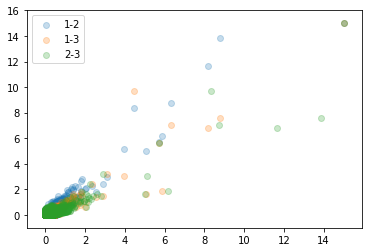

In [0]:
plt.scatter(fourier_matrix_a["phase_1"], fourier_matrix_a["phase_2"],alpha=0.25, label="1-2")
plt.scatter(fourier_matrix_a["phase_1"], fourier_matrix_a["phase_3"],alpha=0.25, label="1-3")
plt.scatter(fourier_matrix_a["phase_2"], fourier_matrix_a["phase_3"],alpha=0.25, label="2-3")
plt.legend()
plt.show()

# Creating Joint Distribution Images

In [0]:
import pandas as pd
import numpy as np

metadata = pd.read_csv('/content/metadata_train.csv')

# Normal
normal_ids = [0, 26, 125, 2315, 2903, 840]
normal_dfs = dict()
# Retrieve individual experiments and compute cropped fft
for items in normal_ids:
  # Retrieval
  signal_ids = list(metadata[metadata["id_measurement"] == items]["signal_id"].values)
  signal_ids = [str(item) for item in signal_ids]
  normal_signal = pd.read_parquet('/content/train/train.parquet',
                                  engine='pyarrow', 
                                  columns=signal_ids)
  # FFT
  normal_dfs[str(items)] = pd.DataFrame(
      {"0": np.abs(np.fft.rfft(normal_signal.iloc[:, 0]))[150000:],
       "1": np.abs(np.fft.rfft(normal_signal.iloc[:, 1]))[150000:],
       "2": np.abs(np.fft.rfft(normal_signal.iloc[:, 2]))[150000:]})
# Normalize fft amplitudes
for key in normal_dfs:
  normal_dfs[key].iloc[:, 0] = normal_dfs[key].iloc[:, 0]*63/max(normal_dfs[key].iloc[:, 0])
  normal_dfs[key].iloc[:, 1] = normal_dfs[key].iloc[:, 1]*63/max(normal_dfs[key].iloc[:, 1])
  normal_dfs[key].iloc[:, 2] = normal_dfs[key].iloc[:, 2]*63/max(normal_dfs[key].iloc[:, 2])
  
    

# Anomalous
anomalous_ids = [1, 67, 76, 90, 525, 1173]
anomalous_dfs = dict()
for items in anomalous_ids:
  # Retrieval
  signal_ids = list(metadata[metadata["id_measurement"] == items]["signal_id"].values)
  signal_ids = [str(item) for item in signal_ids]
  anomalous_signal = pd.read_parquet('/content/train/train.parquet',
                                     engine='pyarrow', 
                                     columns=signal_ids)
  # FFT
  anomalous_dfs[str(items)] = pd.DataFrame(
      {"0": np.abs(np.fft.rfft(anomalous_signal.iloc[:, 0]))[150000:],
       "1": np.abs(np.fft.rfft(anomalous_signal.iloc[:, 1]))[150000:],
       "2": np.abs(np.fft.rfft(anomalous_signal.iloc[:, 2]))[150000:]})
  
# Normalize fft amplitudes
for key in anomalous_dfs:
  anomalous_dfs[key].iloc[:, 0] = anomalous_dfs[key].iloc[:, 0]*63/max(anomalous_dfs[key].iloc[:, 0])
  anomalous_dfs[key].iloc[:, 1] = anomalous_dfs[key].iloc[:, 1]*63/max(anomalous_dfs[key].iloc[:, 1])
  anomalous_dfs[key].iloc[:, 2] = anomalous_dfs[key].iloc[:, 2]*63/max(anomalous_dfs[key].iloc[:, 2])

In [0]:
from PIL import Image

def plot_joint_dist(dfs, measurement_id):
  pixels_r = zip(dfs[measurement_id].iloc[:, 0], 
                 dfs[measurement_id].iloc[:, 1])
  pixels_g = zip(dfs[measurement_id].iloc[:, 0], 
                 dfs[measurement_id].iloc[:, 2])
  pixels_b = zip(dfs[measurement_id].iloc[:, 1], 
                 dfs[measurement_id].iloc[:, 2])
  image_fft = np.zeros((64, 64, 3))
  for item in pixels_r:
    image_fft[int(item[0]), int(item[1]), 0] = image_fft[int(item[0]), int(item[1]), 0] + 1
  image_fft[:, :, 0] = image_fft[:, :, 0]*255/np.amax(image_fft[:, :, 0])
  for item in pixels_g:
    image_fft[int(item[0]), int(item[1]), 1] = image_fft[int(item[0]), int(item[1]), 1] + 1
  image_fft[:, :, 1] = image_fft[:, :, 1]*255/np.amax(image_fft[:, :, 1])
  for item in pixels_b:
    image_fft[int(item[0]), int(item[1]), 2] = image_fft[int(item[0]), int(item[1]), 2] + 1
  image_fft[:, :, 2] = image_fft[:, :, 2]*255/np.amax(image_fft[:, :, 2])
  img = Image.fromarray(image_fft,
                        'RGB')
  plt.title(measurement_id)
  plt.imshow(img)
  plt.show()


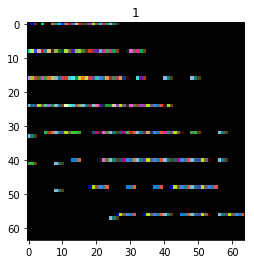

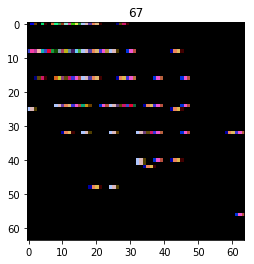

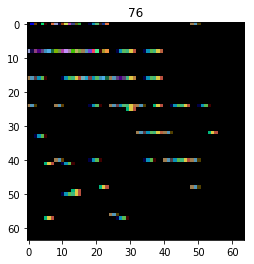

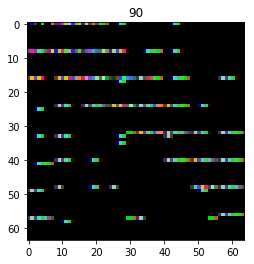

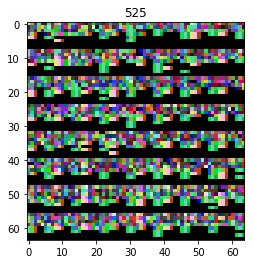

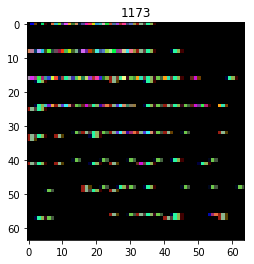

In [0]:
for items in anomalous_ids:
  plot_joint_dist(anomalous_dfs, str(items))

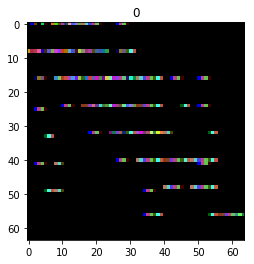

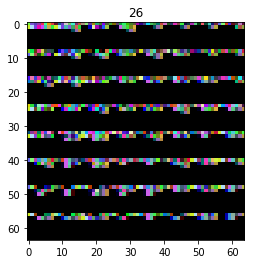

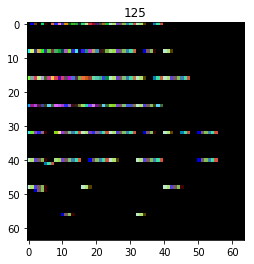

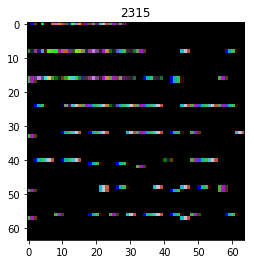

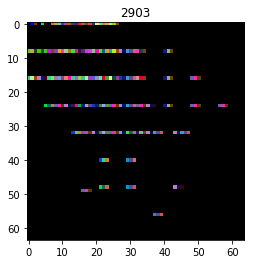

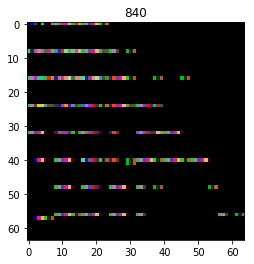

In [0]:
for items in normal_ids:
  plot_joint_dist(normal_dfs, str(items))

# Symmetric components

Studying Normal Signals
533331
533331
533331
533331


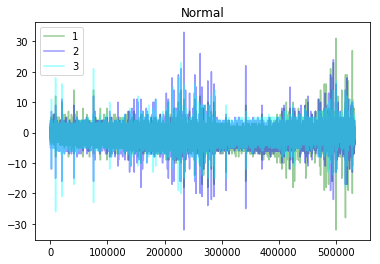

533331
533331
533331
533331


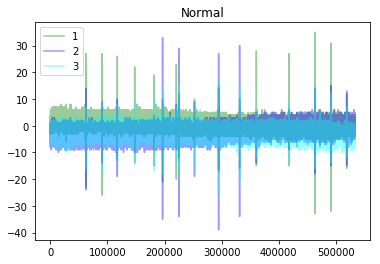

533331
533331
533331
533331


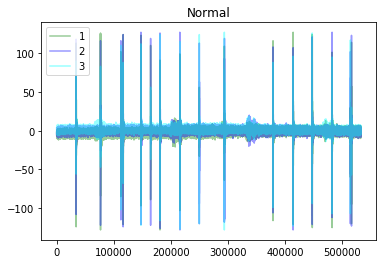

533331
533331
533331
533331


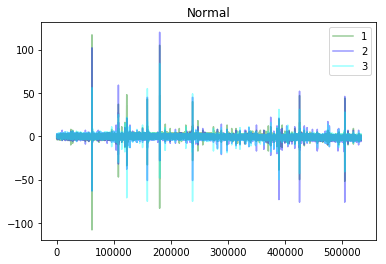

533331
533331
533331
533331


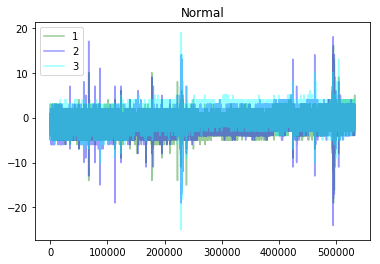

533331
533331
533331
533331


In [0]:
import pandas as pd
import numpy as np

metadata = pd.read_csv('/content/metadata_train.csv')

def get_signal_plot(signals, init_limits, end_limits, phases, with_plot):
  out_signal = signals.iloc[init_limits[0]:end_limits[0], phases[0]].values - signals.iloc[init_limits[1]:end_limits[1], phases[1]].values
  if with_plot:
    plt.plot(out_signal)
    plt.title("phases: "+str(phases[0])+" and "+str(phases[1]))
    plt.show()
  error = sum(abs(out_signal))/len(out_signal)
  return out_signal, error

def get_residual_signals(df, measurement_id, phase_1, phase_2, with_plot=True):
  phasor_len = 266666
  signals = df[measurement_id]
  best_signal = None
  best_error = np.Inf
  init_limits = [[0, phasor_len],
                 [phasor_len, 0],
                 [0, 2*phasor_len],
                 [2*phasor_len, 0]]
  end_limits = [[2*phasor_len-1, 3*phasor_len-1],
                [3*phasor_len-1, 2*phasor_len-1],
                [phasor_len-1, 3*phasor_len-1],
                [3*phasor_len-1, phasor_len-1]]
  for item in zip(init_limits, end_limits):
    out_signal, error = get_signal_plot(signals, 
                                               init_limits = [item[0][0], item[0][1]], 
                                               end_limits = [item[1][0], item[1][1]], 
                                               phases = [phase_1, phase_2],
                                               with_plot=with_plot)
    
    if (error < best_error) & (len(out_signal) > 300000):
      print(len(out_signal))
      best_error = error
      best_signal = out_signal
  return best_signal
  

# Normal
normal_ids = metadata[metadata["target"] == 0]["id_measurement"].unique()[:10]#[0, 26, 125, 2315, 2903, 840]
normal_dfs = dict()
# Retrieve individual experiments and compute cropped fft
for items in normal_ids:
  # Retrieval
  signal_ids = list(metadata[metadata["id_measurement"] == items]["signal_id"].values)
  signal_ids = [str(item) for item in signal_ids]
  normal_signal = pd.read_parquet('/content/train/train.parquet',
                                  engine='pyarrow', 
                                  columns=signal_ids)
  # FFT
  normal_dfs[str(items)] = pd.DataFrame(
      {"0": normal_signal.iloc[:, 0],
       "1": normal_signal.iloc[:, 1],
       "2": normal_signal.iloc[:, 2]})    

normal_all = []
print("Studying Normal Signals")
for items in normal_ids:
  s1 = get_residual_signals(normal_dfs, str(items), 0, 1, False)
  plt.plot(s1, c="green", label="1", alpha=0.4)
  normal_all.append([np.mean(s1), np.var(s1), 1, 0])
  s2 = get_residual_signals(normal_dfs, str(items), 0, 2, False)
  plt.plot(s2, c="blue", label="2", alpha=0.4)
  normal_all.append([np.mean(s2), np.var(s2), 2, 0])
  s3 = get_residual_signals(normal_dfs, str(items), 1, 2, False)
  normal_all.append([np.mean(s3), np.var(s3), 3, 0])
  plt.plot(s3, c="cyan", label="3", alpha=0.4)
  plt.legend()
  plt.title("Normal")
  plt.show()
  
# Anomalous
anomalous_ids = metadata[metadata["target"] == 1]["id_measurement"].unique()[:10]#[1, 67, 76, 90, 525, 1173]
anomalous_dfs = dict()
for items in anomalous_ids:
  # Retrieval
  signal_ids = list(metadata[metadata["id_measurement"] == items]["signal_id"].values)
  signal_ids = [str(item) for item in signal_ids]
  anomalous_signal = pd.read_parquet('/content/train/train.parquet',
                                     engine='pyarrow', 
                                     columns=signal_ids)
  # FFT
  anomalous_dfs[str(items)] = pd.DataFrame(
      {"0": anomalous_signal.iloc[:, 0],
       "1": anomalous_signal.iloc[:, 1],
       "2": anomalous_signal.iloc[:, 2]})

print("Studying Anomalous Signals")
for items in anomalous_ids:
  s1 = get_residual_signals(anomalous_dfs, str(items), 0, 1, False)
  plt.plot(s1, c="red", label="1", alpha=0.4)
  normal_all.append([np.mean(s1), np.var(s1), 1, 1])
  s2 = get_residual_signals(anomalous_dfs, str(items), 0, 2, False)
  plt.plot(s3, c="yellow", label="3", alpha=0.4)
  normal_all.append([np.mean(s2), np.var(s2), 2, 1])
  s3 = get_residual_signals(anomalous_dfs, str(items), 1, 2, False)
  normal_all.append([np.mean(s3), np.var(s3), 3, 1])
  plt.plot(s3, c="black", label="3", alpha=0.4)
  plt.legend()
  plt.title("Anomalous")
  plt.show()

normal_all = pd.DataFrame(normal_all, columns=["mean", "variance", "cases", "target"])

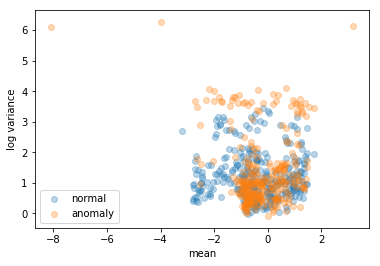

In [0]:
plt.scatter(normal_all[normal_all["target"] == 0]["mean"],
            np.log(normal_all[normal_all["target"] == 0]["variance"]),
            alpha=0.3, label="normal")
plt.scatter(normal_all[normal_all["target"] == 1]["mean"], 
         np.log(normal_all[normal_all["target"] == 1]["variance"]),
         alpha=0.3, label="anomaly")
plt.xlabel("mean")
plt.ylabel("log variance")
#plt.ylim(0, 5)
plt.legend()
plt.show()